In [74]:
# import warnings
# warnings.filterwarnings("ignore", category=SettingWithCopyWarning)
import os
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
import xgboost as xgb
from pmdarima import auto_arima
import joblib

In [2]:
#df =pd.read_csv("drive/My Drive/Optiver_Data/train.csv")
df = pd.read_csv('train.csv')

In [3]:
df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


**Features Description**:

**stock_id** - A unique identifier for the stock. Not all stock IDs exist in every time bucket.

**date_id** - A unique identifier for the date. Date IDs are sequential & consistent across all stocks.

**imbalance_size** - The amount unmatched at the current reference price (in USD).

**imbalance_buy_sell_flag** - An indicator reflecting the direction of auction imbalance.

    buy-side imbalance; 1
    sell-side imbalance; -1
    no imbalance; 0

**reference_price** - The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price.

**matched_size** - The amount that can be matched at the current reference price (in USD).

**far_price** - The crossing price that will maximize the number of shares matched based on auction interest only. This calculation excludes continuous market orders.

**near_price** - The crossing price that will maximize the number of shares matched based auction and continuous market orders.

**[bid/ask]_price** - Price of the most competitive buy/sell level in the non-auction book.

**[bid/ask]_size** - The dollar notional amount on the most competitive buy/sell level in the non-auction book.

**wap** - The weighted average price in the non-auction book.

**seconds_in_bucket** - The number of seconds elapsed since the beginning of the day's closing auction, always starting from 0.

**target** - The 60 second future move in the wap of the stock, less the 60 second future move of the synthetic index. Only provided for the train set.

In [5]:
df.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756125e-02,1.331005e+04
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00,7.619271e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02,2.645400e+04


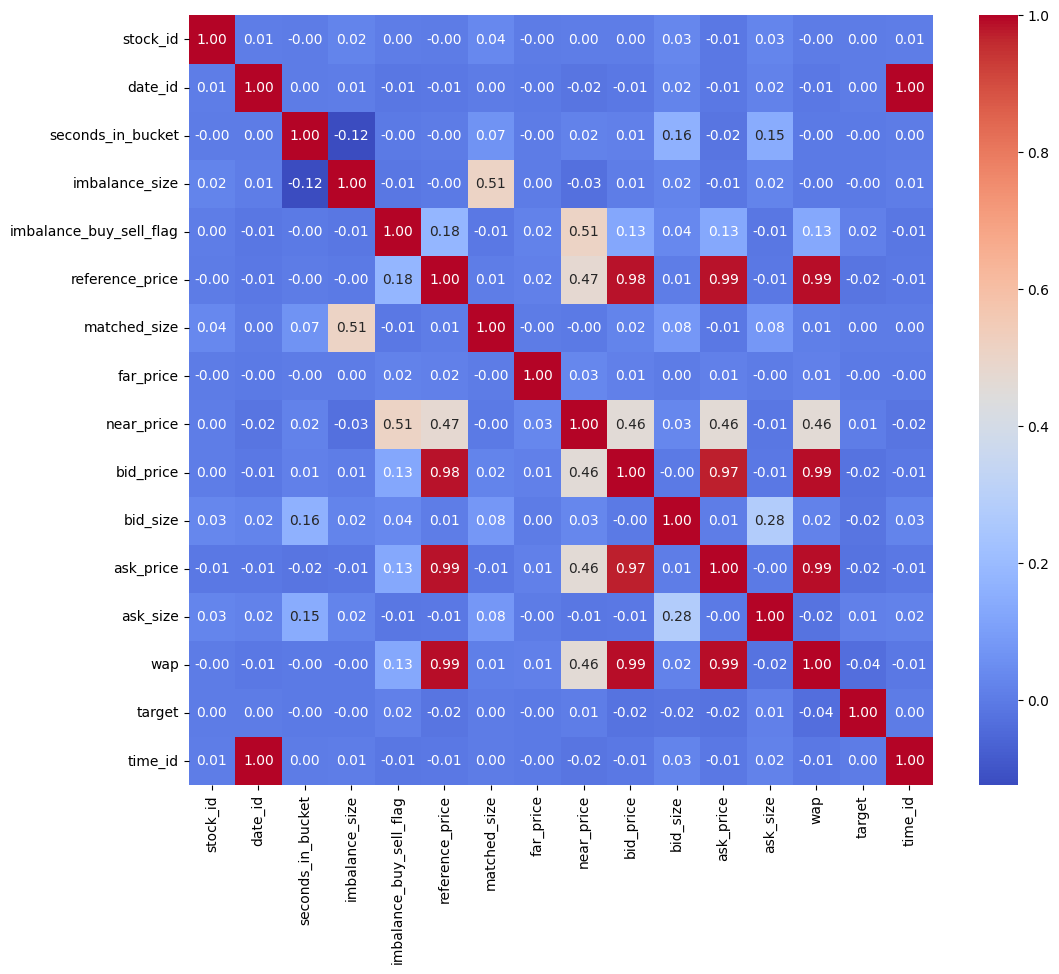

In [6]:
df_corr = df.drop('row_id', axis=1)
correlation_matrix = df_corr.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
# plt.show()
plt.savefig('heatmap.png')

Also, `time_id` is highly correlated to `date_id`. Therefore we can drop `time_id`

In [7]:
stocks = df['stock_id'].sort_values(ascending=True).unique()
stocks

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

there are a total of 200 stocks

In [8]:
records_per_stock = pd.DataFrame(df['stock_id'].value_counts().sort_index(ascending=True)).reset_index()
records_per_stock.columns = ['stock_id','count']
print(records_per_stock)

     stock_id  count
0           0  26455
1           1  26455
2           2  26455
3           3  26455
4           4  26455
..        ...    ...
195       195  26455
196       196  26455
197       197  26455
198       198  26455
199       199  21615

[200 rows x 2 columns]


In [9]:
pd.DataFrame(df.groupby('stock_id')['date_id'].value_counts())

count
stock_id date_id       
0        0           55
         1           55
         244         55
         253         55
         252         55
...                 ...
199      231         55
         230         55
         229         55
         228         55
         480         55

[95236 rows x 1 columns]

There are total of 481 dates with almost all have around 55 records or instances.

In [10]:
df.groupby('stock_id')['date_id'].nunique().value_counts()

date_id
481    189
444      2
480      2
477      1
300      1
186      1
290      1
422      1
411      1
393      1
Name: count, dtype: int64

among which, 189 stocks have 481 date_ids and the rest of the stocks have lesser than 381 stocks.

In [11]:
date_counts = df.groupby(['stock_id', 'date_id']).size().reset_index(name='count')

max_date_counts_per_stock = date_counts['count'].max()
min_date_counts_per_stock = date_counts['count'].min()

print(max_date_counts_per_stock, min_date_counts_per_stock)

55 55


Lets Consider a small sample of the data to visualize

In [12]:
df_stock_id_1 = df[df['stock_id'] == 1].iloc[:2000,:].reset_index()
df_stock_id_1

,index,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
1,192,1,0,10,165923.20,-1,0.999955,1642894.96,NaN,NaN,0.999896,3743.52,1.000660,33717.42,0.999973,-1.620054,1,0_10_1
2,383,1,0,20,165923.20,-1,0.999955,1642894.96,NaN,NaN,0.999896,3743.52,1.000660,33717.42,0.999973,-6.459951,2,0_20_1
3,574,1,0,30,165923.20,-1,0.999896,1642894.96,NaN,NaN,0.999896,4254.00,1.000308,3574.83,1.000120,-5.149841,3,0_30_1
4,765,1,0,40,162349.47,-1,0.999955,1646468.69,NaN,NaN,0.999896,21270.00,1.000308,3574.83,1.000248,-6.750226,4,0_40_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,382821,1,36,150,811540.95,-1,0.999539,1778082.90,NaN,NaN,0.999539,184.44,1.000027,922.65,0.999621,0.330210,1995,36_150_1
1996,383013,1,36,160,774266.90,-1,0.999919,1815356.95,NaN,NaN,0.999810,2582.86,1.000732,738.64,1.000527,-5.639792,1996,36_160_1
1997,383205,1,36,170,754338.20,-1,1.000379,1835285.65,NaN,NaN,0.999810,9040.01,1.000732,738.64,1.000662,-5.850196,1997,36_170_1
1998,383397,1,36,180,630521.93,-1,0.999919,1968881.75,NaN,NaN,0.999810,18449.00,1.000732,4431.84,1.000553,1.280308,1998,36_180_1


# `wap` - Weighted Average Price


Text(0.5, 1.0, 'Line Plot of WAP, Bid Price, and Ask Price')

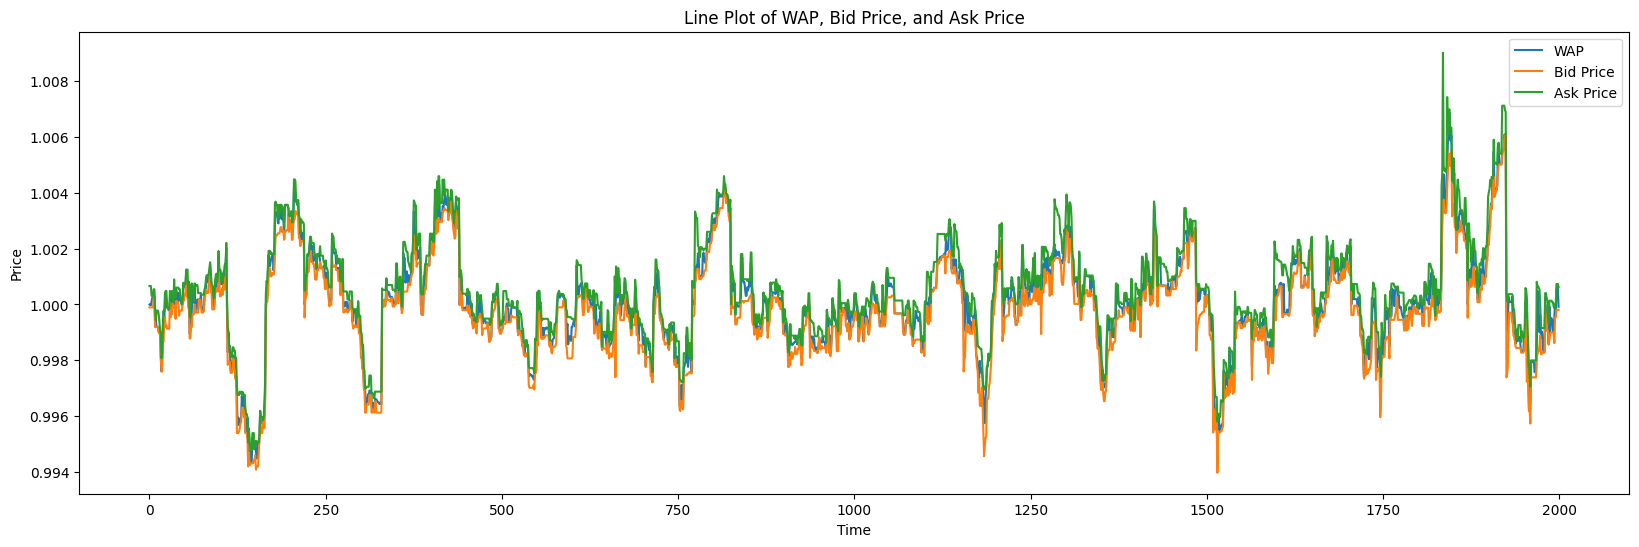

In [13]:
# df_long = pd.melt(df[['wap','bid_price','ask_price']], var_name='price type', value_name='Price')

plt.figure(figsize=(20, 6))
sns.lineplot(x=df_stock_id_1['time_id'], y='wap', data=df_stock_id_1,label='WAP')
sns.lineplot(x=df_stock_id_1['time_id'], y='bid_price', data = df_stock_id_1,label='Bid Price')
sns.lineplot(x=df_stock_id_1['time_id'], y='ask_price', data=df_stock_id_1,label='Ask Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.title('Line Plot of WAP, Bid Price, and Ask Price')


As we can see, the bid_price, ask_price and wap follow the same pattern.
That is because as provided with the feature description


WAP =( BidPrice*AskSize + AskPrice * BidSize) / AskSize + BidSize

The higher the bid size,i.e. more buyers, the higher would be the MAP value

The higher be the ask size, i.e more sellers, the lower would be the MAP value



# `reference_price`
The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price.


Text(0.5, 1.0, 'Line Plot of WAP and Reference Price')

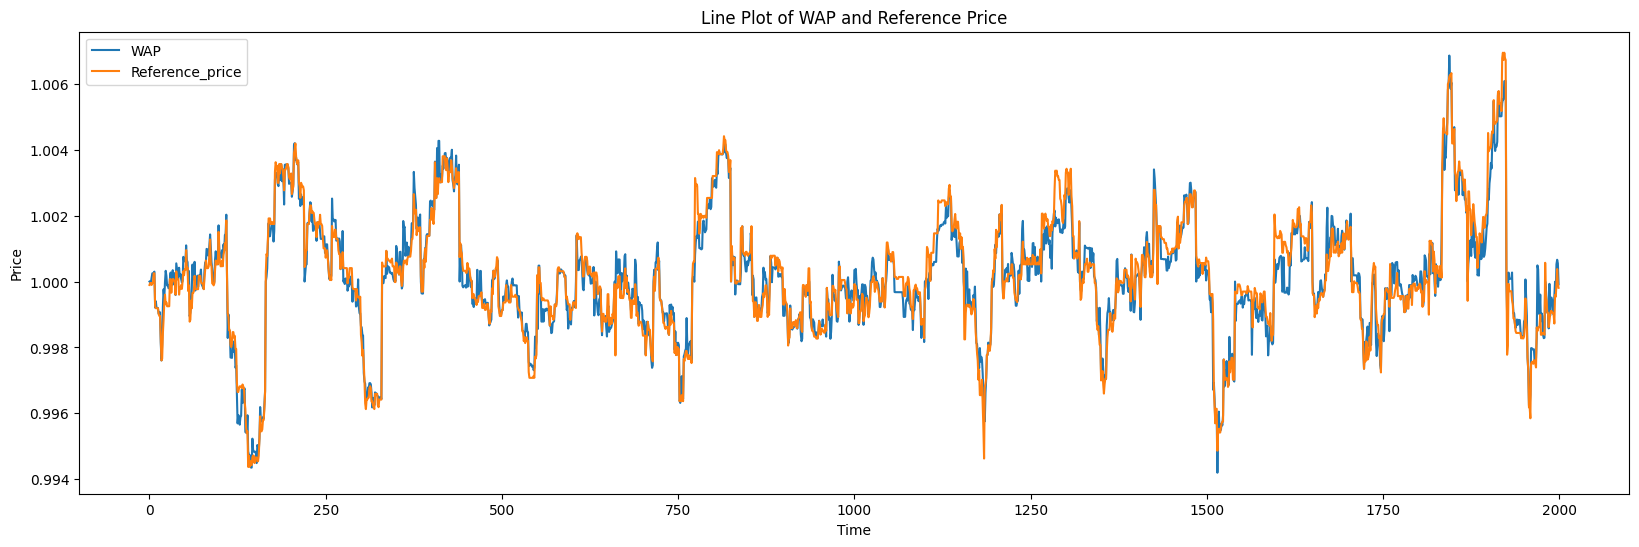

In [14]:
plt.figure(figsize=(20, 6))
sns.lineplot(x=df_stock_id_1['time_id'], y='wap', data=df_stock_id_1,label='WAP')
sns.lineplot(x=df_stock_id_1['time_id'], y='reference_price', data = df_stock_id_1,label='Reference_price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.title('Line Plot of WAP and Reference Price')

Text(0.5, 1.0, 'Line Plot of Bid and Reference Price')

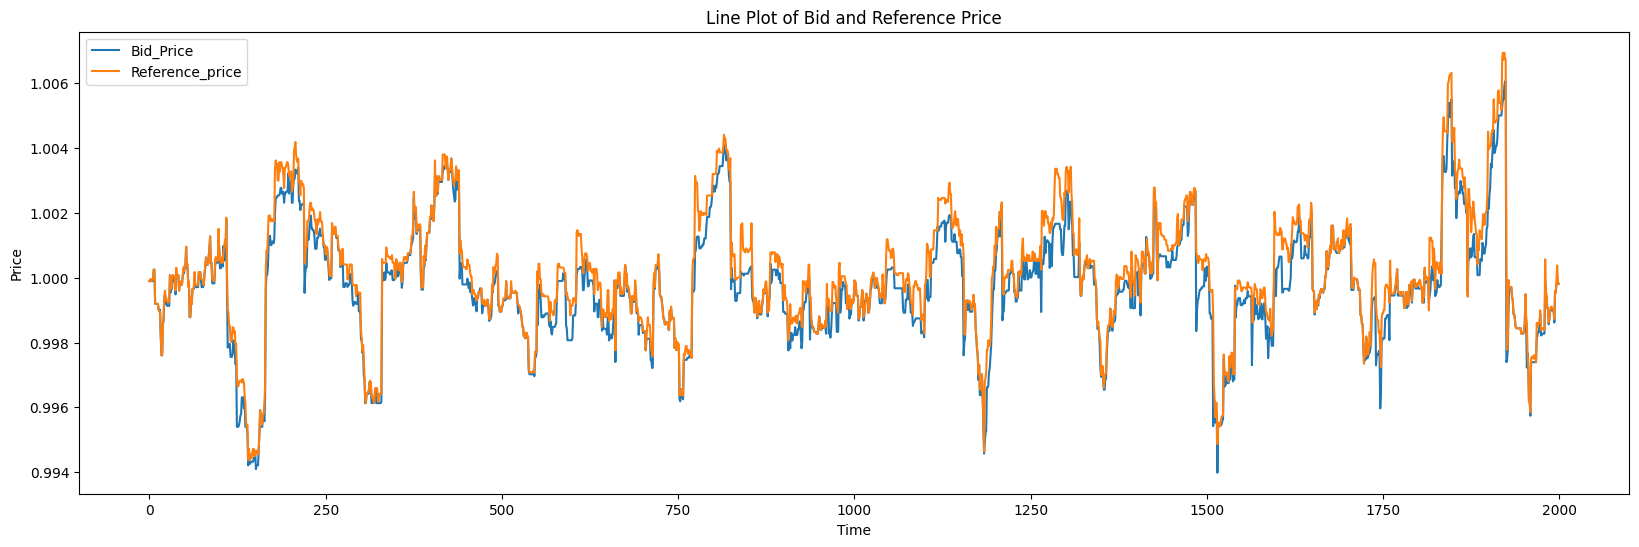

In [15]:
plt.figure(figsize=(20, 6))
sns.lineplot(x=df_stock_id_1['time_id'], y='bid_price', data=df_stock_id_1,label='Bid_Price')
sns.lineplot(x=df_stock_id_1['time_id'], y='reference_price', data = df_stock_id_1,label='Reference_price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.title('Line Plot of Bid and Reference Price')

Text(0.5, 1.0, 'Line Plot of Ask and Reference Price')

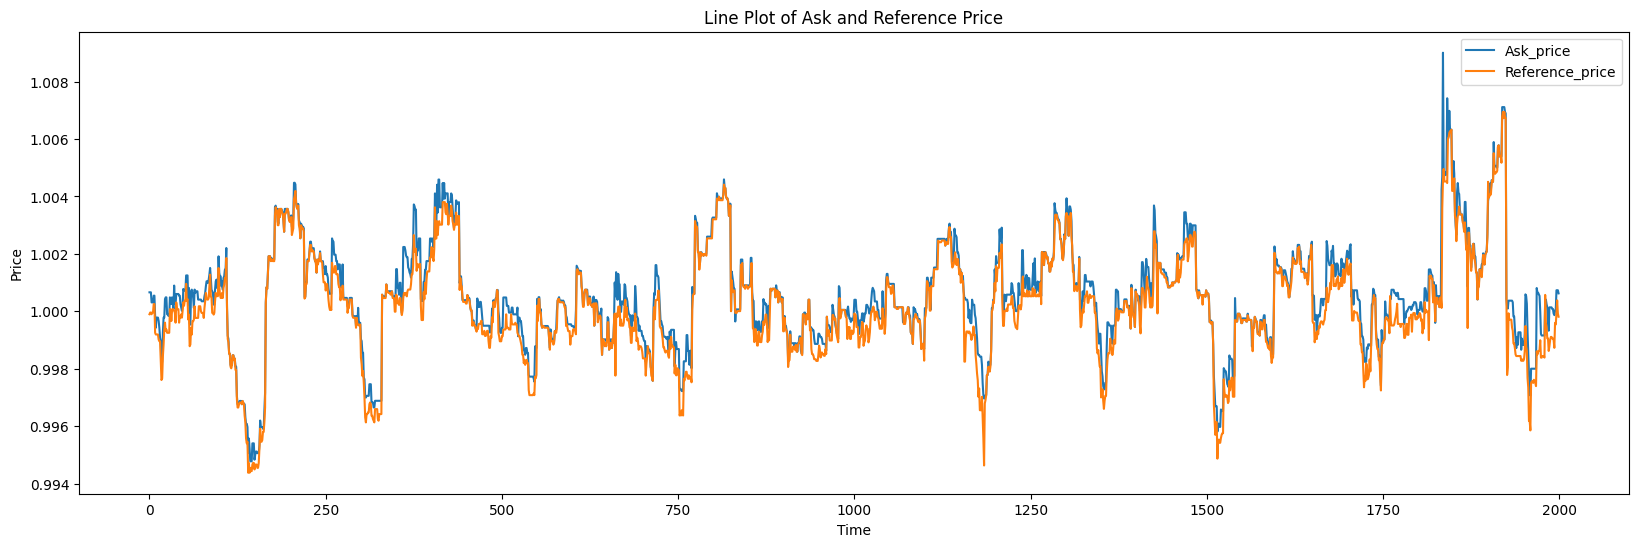

In [16]:
plt.figure(figsize=(20, 6))
sns.lineplot(x=df_stock_id_1['time_id'], y='ask_price', data=df_stock_id_1,label='Ask_price')
sns.lineplot(x=df_stock_id_1['time_id'], y='reference_price', data = df_stock_id_1,label='Reference_price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.title('Line Plot of Ask and Reference Price')

From the graphs, we can see that there is a pattern between the ask price, near price

Also, from the correlation matrix, AskPrice, BidPrice and reference_price are highly correlated so, we can actually loose the AskPrice, BidPrice and reference_price for training and just use WAP  

# `Target`
The 60 second future move in the wap of the stock, minus the 60 second future move of the synthetic index. Only provided for the train set.

The synthetic index is a custom weighted index of Nasdaq-listed stocks constructed by Optiver for this competition.

Text(0.5, 1.0, 'Line Plot of WAP and Target')

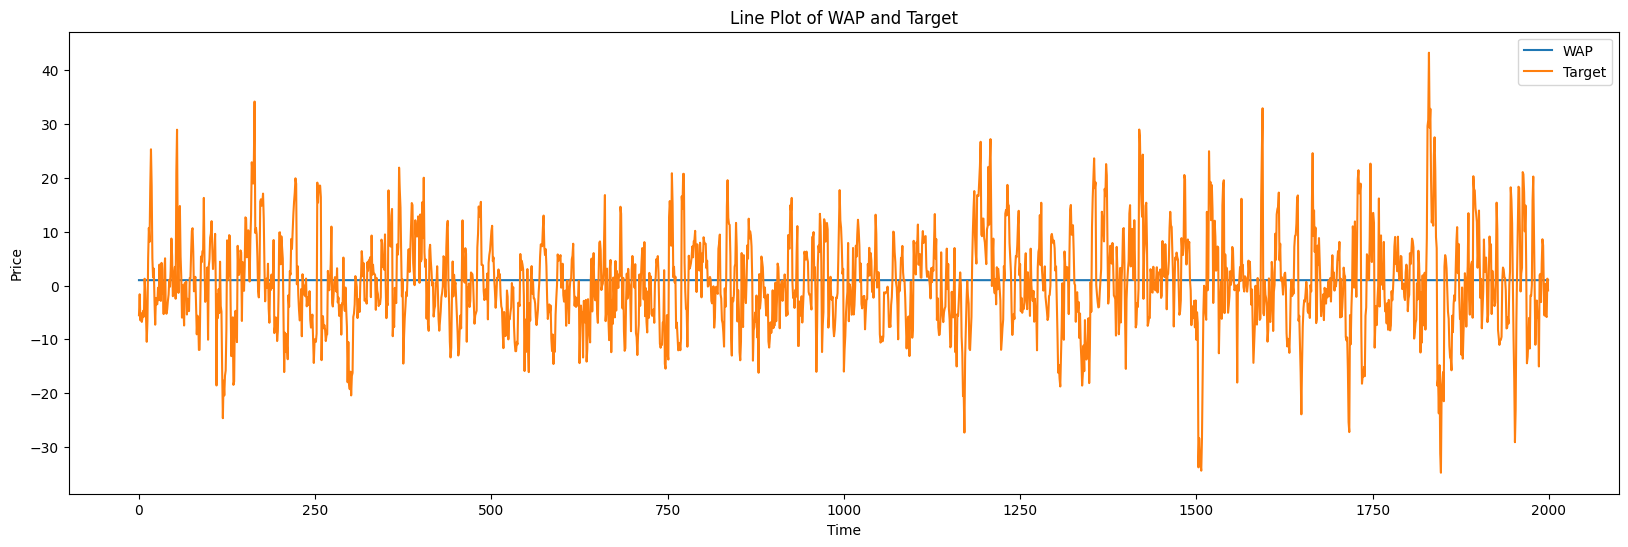

In [17]:
plt.figure(figsize=(20, 6))
sns.lineplot(x=df_stock_id_1['time_id'], y='wap', data=df_stock_id_1,label='WAP')
sns.lineplot(x=df_stock_id_1['time_id'], y='target', data = df_stock_id_1,label='Target')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.title('Line Plot of WAP and Target')

From the description of target variable, we can understand that the wap has significance over the target variable.

And basically, the current target is dependent on the future WAP value. Therefore, the previous target variable can be used as the feature to predict the current target when solving it as a timeseries problem.

# `Far Price` and `Near Price`

When the continuous market orders are not considered, the `Far Price` is the price which results in the maximum number of matched shares based solely on the existing auction interest in the order book.

On the other hand, `Near Price` maximizes the number of shares based on both action interest and continuous market orders. This information is provided by Nasdaq 5 minutes before the closing cross.

Value of the reference price can be defined by the near price value:

If Near Price lies between the ask price and bid price, the reference price would be close to the Near Price.

If Near Price is more than best ask price, reference price is set to the best ask

If Near Price is less than the best bid, reference price is set to the bid

Text(0.5, 1.0, 'Line Plot of Bid, Ask, Far, Near and Reference Prices')

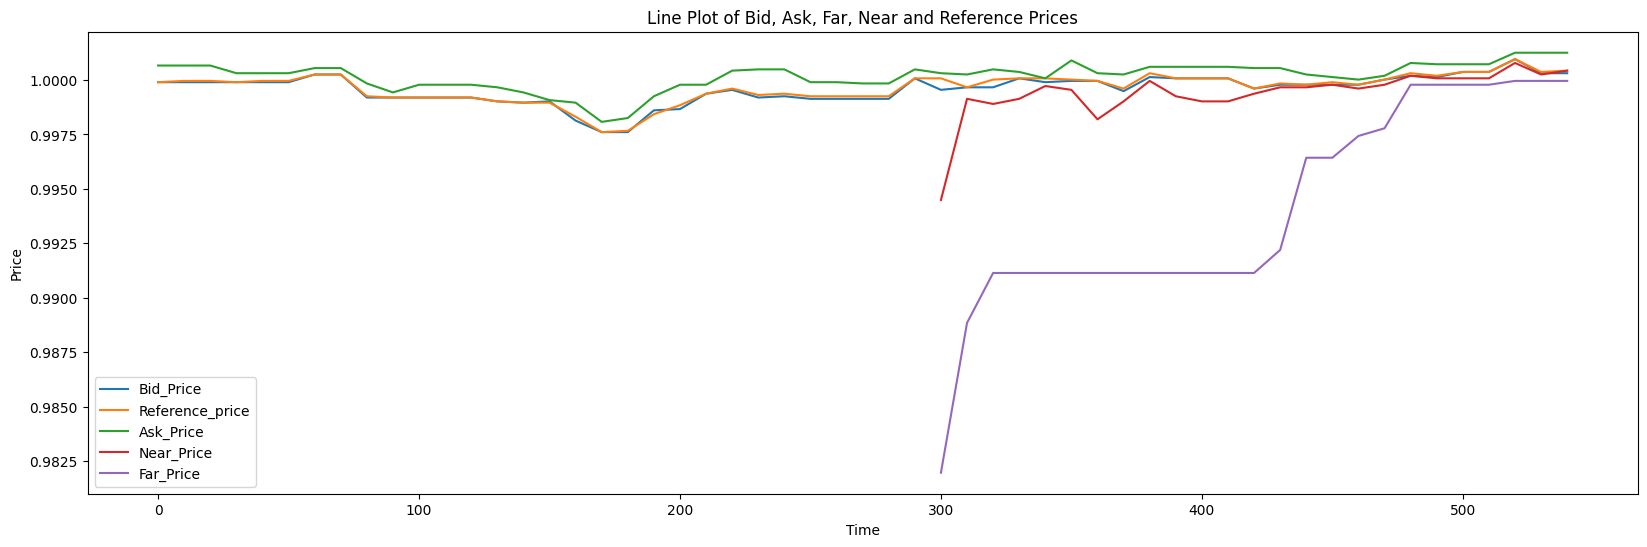

In [18]:
## checking the relation of ask_price, bid_price, reference_price, near_price and far_price
## on a particular day, as the far_price, near_price change on each day for each seconds_in_bucket
df_stock_id_1_date_id_0 = df_stock_id_1[df_stock_id_1['date_id']==0]

plt.figure(figsize=(20, 6))
sns.lineplot(x=df_stock_id_1_date_id_0['seconds_in_bucket'], y='bid_price', data=df_stock_id_1_date_id_0,label='Bid_Price')
sns.lineplot(x=df_stock_id_1_date_id_0['seconds_in_bucket'], y='reference_price', data = df_stock_id_1_date_id_0,label='Reference_price')
sns.lineplot(x=df_stock_id_1_date_id_0['seconds_in_bucket'], y='ask_price', data=df_stock_id_1_date_id_0,label='Ask_Price')
sns.lineplot(x=df_stock_id_1_date_id_0['seconds_in_bucket'], y='near_price', data=df_stock_id_1_date_id_0,label='Near_Price')
sns.lineplot(x=df_stock_id_1_date_id_0['seconds_in_bucket'], y='far_price', data=df_stock_id_1_date_id_0,label='Far_Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.title('Line Plot of Bid, Ask, Far, Near and Reference Prices')

# `imbalance_size` and `imbalance_buy_sell_flag`

Imbalance_size denotes the number of unmatched shares at the reference price and buy/sell flag indicates the direction of the market for the particular stock. Whether is towards buying side or towards selling size.

Text(0.5, 1.0, 'Imbalance_buy_sell_flag ~ Imbalance Size Box Plot For Stock_ID 1')

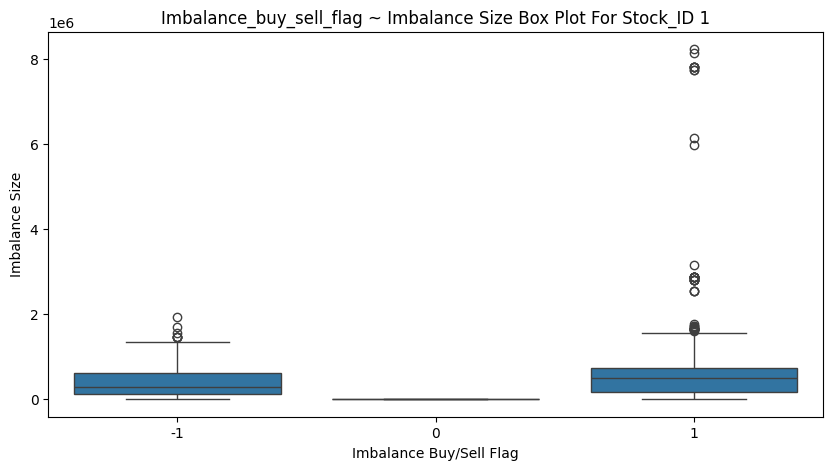

In [19]:
plt.figure(figsize=(10,5))
sns.boxplot(x='imbalance_buy_sell_flag', y = 'imbalance_size', data = df_stock_id_1 )
plt.xlabel('Imbalance Buy/Sell Flag')
plt.ylabel('Imbalance Size')
plt.title('Imbalance_buy_sell_flag ~ Imbalance Size Box Plot For Stock_ID 1')

based on the box plot, both -1 and +1 flags have comparably close imbalance sizes but more that 0 flag have very less values - can be zero too.

and also have outliers

Text(0.5, 1.0, 'Imbalance_buy_sell_flag ~ Target Box Plot For Stock_ID 1')

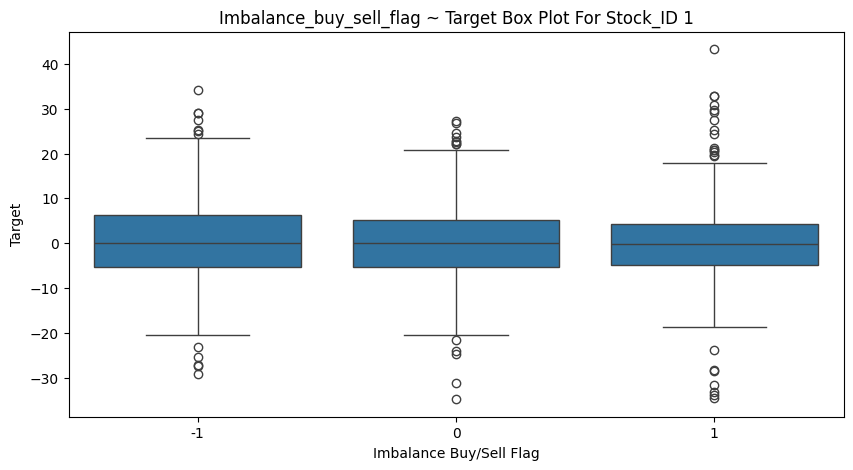

In [20]:
plt.figure(figsize=(10,5))
sns.boxplot(x='imbalance_buy_sell_flag', y = 'target', data = df_stock_id_1 )
plt.xlabel('Imbalance Buy/Sell Flag')
plt.ylabel('Target')
plt.title('Imbalance_buy_sell_flag ~ Target Box Plot For Stock_ID 1')

For each of the flags, the median target is 0 and the distribution is also similar. Lets check the same with other stock _id

Text(0.5, 1.0, 'Imbalance_buy_sell_flag ~ Target Box Plot for Stock_Id- 10 ')

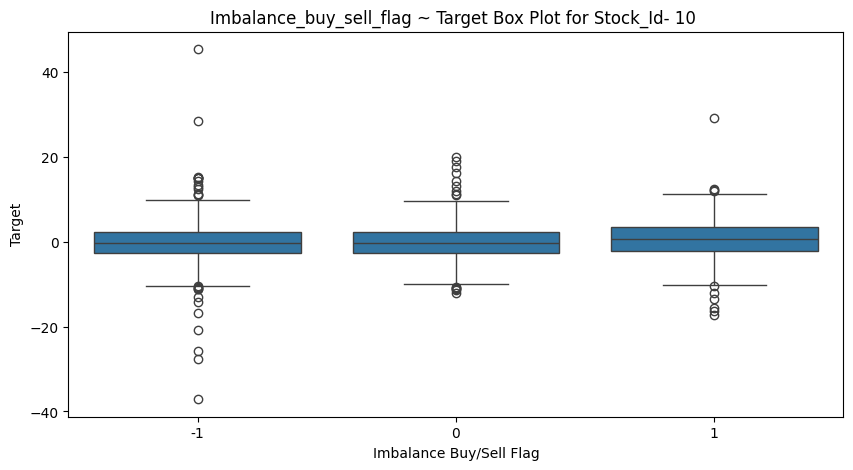

In [21]:
df_stock_id_10 = df[df['stock_id'] == 10].iloc[:2000,:].reset_index()

plt.figure(figsize=(10,5))
sns.boxplot(x='imbalance_buy_sell_flag', y = 'target', data = df_stock_id_10 )
plt.xlabel('Imbalance Buy/Sell Flag')
plt.ylabel('Target')
plt.title('Imbalance_buy_sell_flag ~ Target Box Plot for Stock_Id- 10 ')

Text(0.5, 1.0, 'Imbalance_buy_sell_flag ~ Target Box Plot for Stock_Id-15')

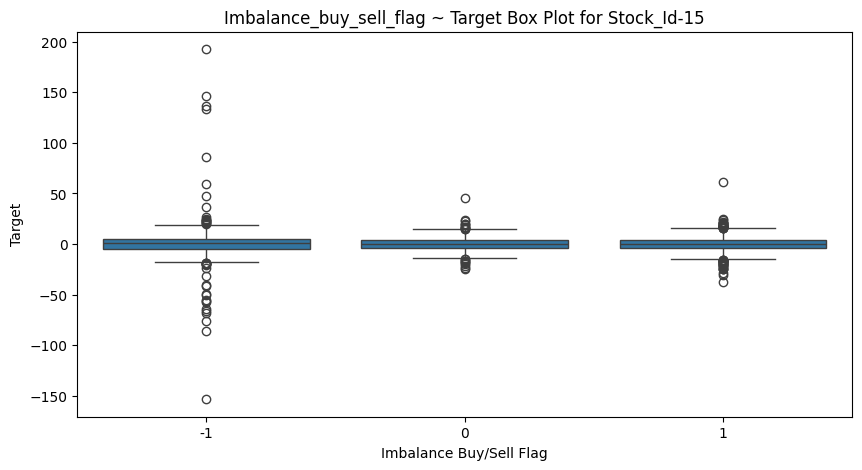

In [22]:
df_stock_id_15 = df[df['stock_id'] == 15].iloc[:2000,:].reset_index()

plt.figure(figsize=(10,5))
sns.boxplot(x='imbalance_buy_sell_flag', y = 'target', data = df_stock_id_15 )
plt.xlabel('Imbalance Buy/Sell Flag')
plt.ylabel('Target')
plt.title('Imbalance_buy_sell_flag ~ Target Box Plot for Stock_Id-15')

From the other 2 stock_id's box plot its safe to assume that, the imbalance_buy_sell_flag has no good significance over the target.

# `matched_size`
The amount that can be matched at the current reference price (in USD).

Text(0.5, 1.0, 'Line Plot of Matched Size and Imbalance Size')

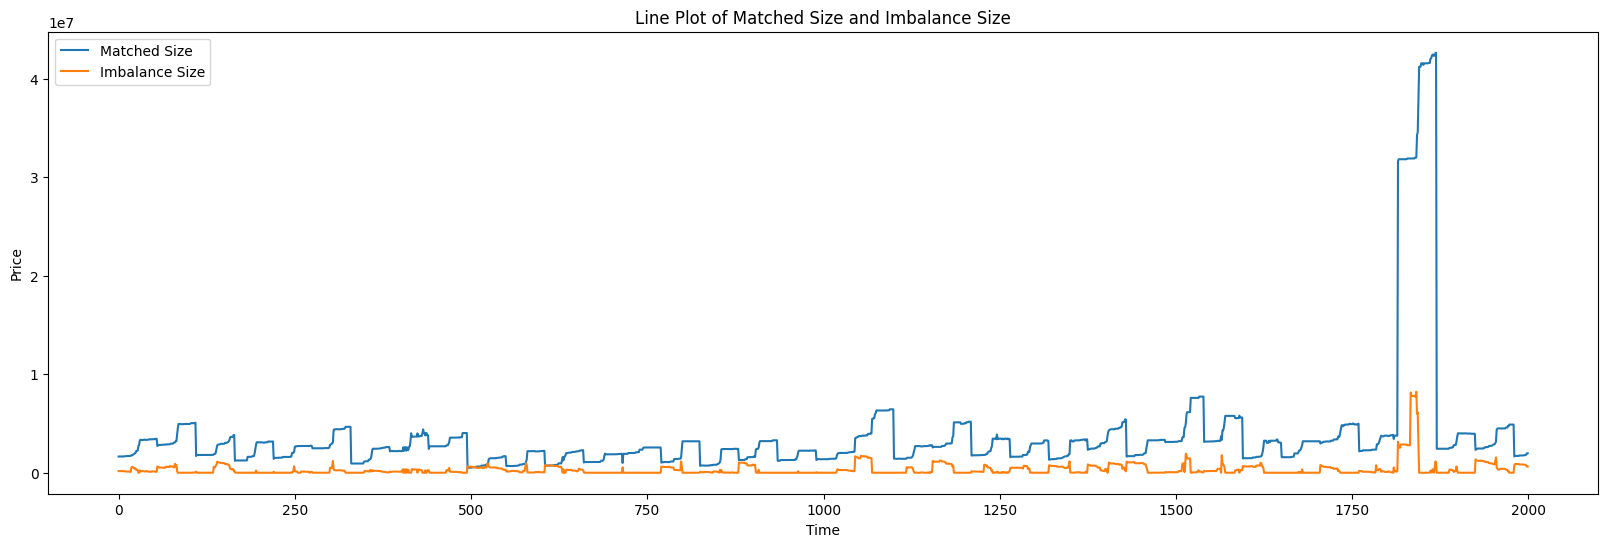

In [23]:
plt.figure(figsize=(20, 6))
sns.lineplot(x=df_stock_id_1['time_id'], y='matched_size', data=df_stock_id_1,label='Matched Size')
sns.lineplot(x=df_stock_id_1['time_id'], y='imbalance_size', data = df_stock_id_1,label='Imbalance Size')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.title('Line Plot of Matched Size and Imbalance Size')

# `row_id`

row id is the combination of date_id , stock_id, seconds_in_bucket

In [24]:
df[['date_id','seconds_in_bucket','stock_id','row_id']]


,date_id,seconds_in_bucket,stock_id,row_id
0,0,0,0,0_0_0
1,0,0,1,0_0_1
2,0,0,2,0_0_2
3,0,0,3,0_0_3
4,0,0,4,0_0_4
...,...,...,...,...
5237975,480,540,195,480_540_195
5237976,480,540,196,480_540_196
5237977,480,540,197,480_540_197
5237978,480,540,198,480_540_198


## Kaggle Citation

https://www.kaggle.com/code/lukaszsztukiewicz/ml-in-timeseries-feature-engineering 

This code is borrowed from one of the Kaggle Notebooks which helps reduce the size of the dataset once it's loaded into the memory. This helps speed up data processing and training tasks.

In [25]:
def reduce_mem_usage(df, verbose=0):
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                else:
                    df[col] = df[col].astype(np.float32)

    print(f"Memory usage of dataframe is {start_mem:.2f} MB")
    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage after optimization is: {end_mem:.2f} MB")
    decrease = 100 * (start_mem - end_mem) / start_mem
    print(f"Decreased by {decrease:.2f}%")

    return df

df = reduce_mem_usage(df, verbose=1)

Memory usage of dataframe is 679.36 MB
Memory usage after optimization is: 234.78 MB
Decreased by 65.44%


In [26]:
TOTAL_STOCKS = 200
TOTAL_DATES = 481
TOTAL_SECONDS_IN_BUCKET = 55


def handle_missing_date_and_seconds(org_df):

    ideal_index = pd.MultiIndex.from_product([range(TOTAL_STOCKS),range(TOTAL_DATES), [ j * 10 for j in range(TOTAL_SECONDS_IN_BUCKET)]]
        ,names = ['stock_id','date_id','seconds_in_bucket'])
    updated_small_df = org_df.set_index(['stock_id','date_id','seconds_in_bucket']).reindex(ideal_index)
    updated_small_df = updated_small_df.reset_index()
    return updated_small_df

updated_df = handle_missing_date_and_seconds(df)


In [27]:
updated_df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.750,1.0,1.000000,13380277.0,NaN,NaN,1.000000,60651.500000,1.000000,8493.030273,1.000000,-3.029297,0.0,0_0_0
1,0,0,10,1299772.750,1.0,1.000000,15261107.0,NaN,NaN,1.000000,13996.500000,1.000000,23519.160156,1.000000,0.389893,1.0,0_10_0
2,0,0,20,1299772.750,1.0,1.000000,15261107.0,NaN,NaN,1.000000,4665.500000,1.000000,12131.599609,1.000000,4.218750,2.0,0_20_0
3,0,0,30,1299772.750,1.0,1.000000,15261107.0,NaN,NaN,1.000000,55998.000000,1.000000,46203.300781,1.000000,5.449219,3.0,0_30_0
4,0,0,40,1218204.375,1.0,1.000000,15342675.0,NaN,NaN,1.000000,14655.950195,1.000000,26610.449219,1.000000,3.169922,4.0,0_40_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5290995,199,480,500,2661783.500,-1.0,1.002930,23969216.0,1.000977,1.001953,1.002930,122246.179688,1.002930,425296.156250,1.002930,-7.210938,26450.0,480_500_199
5290996,199,480,510,2658917.500,-1.0,1.002930,23972082.0,1.000977,1.001953,1.002930,677012.062500,1.002930,347268.875000,1.002930,-9.750000,26451.0,480_510_199
5290997,199,480,520,1352558.875,-1.0,1.001953,23978380.0,1.000977,1.001953,1.001953,225361.656250,1.001953,194630.515625,1.001953,3.630859,26452.0,480_520_199
5290998,199,480,530,1352558.875,-1.0,1.001953,23978380.0,1.000977,1.001953,1.001953,285559.062500,1.001953,214513.312500,1.001953,4.761719,26453.0,480_530_199


In [28]:
updated_df.isna().any()

stock_id                   False
date_id                    False
seconds_in_bucket          False
imbalance_size              True
imbalance_buy_sell_flag     True
reference_price             True
matched_size                True
far_price                   True
near_price                  True
bid_price                   True
bid_size                    True
ask_price                   True
ask_size                    True
wap                         True
target                      True
time_id                     True
row_id                      True
dtype: bool

As from the results of EDA, we are removing the following features from the udpated dataframe

In [29]:
updated_df.drop(['reference_price','bid_price','ask_price','time_id','row_id'],axis=1,inplace=True)

In [30]:
updated_df.shape,updated_df.columns

((5291000, 12),
 Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
        'imbalance_buy_sell_flag', 'matched_size', 'far_price', 'near_price',
        'bid_size', 'ask_size', 'wap', 'target'],
       dtype='object'))

In [31]:
updated_df = reduce_mem_usage(updated_df, verbose=1)

Memory usage of dataframe is 282.57 MB
Memory usage after optimization is: 161.47 MB
Decreased by 42.86%


As the dataset set is really huge, we will only consider data of stock_id 1 for the implementation of the models

In [32]:
updated_stock_1_df = updated_df[updated_df['stock_id'] == 1]
updated_stock_1_df = updated_stock_1_df.reset_index(drop=True)
updated_stock_1_df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,matched_size,far_price,near_price,bid_size,ask_size,wap,target
0,1,0,0,166603.906250,-1.0,1642214.25,NaN,NaN,3233.040039,20605.089844,1.000000,-5.519531
1,1,0,10,165923.203125,-1.0,1642895.00,NaN,NaN,3743.520020,33717.421875,1.000000,-1.620117
2,1,0,20,165923.203125,-1.0,1642895.00,NaN,NaN,3743.520020,33717.421875,1.000000,-6.460938
3,1,0,30,165923.203125,-1.0,1642895.00,NaN,NaN,4254.000000,3574.830078,1.000000,-5.148438
4,1,0,40,162349.468750,-1.0,1646468.75,NaN,NaN,21270.000000,3574.830078,1.000000,-6.750000
...,...,...,...,...,...,...,...,...,...,...,...,...
26450,1,480,500,88468.406250,-1.0,7635810.50,0.996094,0.996582,176306.437500,64345.000000,0.996582,2.849609
26451,1,480,510,310778.500000,-1.0,7413500.50,0.996094,0.996582,1324.329956,47135.699219,0.996582,3.169922
26452,1,480,520,310778.500000,-1.0,7413500.50,0.996094,0.996582,3783.800049,85374.296875,0.996582,5.691406
26453,1,480,530,310778.500000,-1.0,7413500.50,0.996094,0.996582,7567.600098,112065.601562,0.996582,10.648438


In [33]:
updated_stock_1_df.isnull().sum()

stock_id                       0
date_id                        0
seconds_in_bucket              0
imbalance_size                 0
imbalance_buy_sell_flag        0
matched_size                   0
far_price                  14671
near_price                 14430
bid_size                       0
ask_size                       0
wap                            0
target                         0
dtype: int64

In [34]:
updated_stock_1_df[updated_stock_1_df['far_price'].isnull()].index

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       26420, 26421, 26422, 26423, 26424, 26425, 26426, 26427, 26428, 26429],
      dtype='int64', length=14671)

In [35]:
updated_stock_1_df[updated_stock_1_df['near_price'].isnull()].index

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       26420, 26421, 26422, 26423, 26424, 26425, 26426, 26427, 26428, 26429],
      dtype='int64', length=14430)

Take the data from this (preprocessed). Input scaling. Dropping vs Imputing features. We can build mdoels for 2-3 stocks instead of the whole data. Use this same preprocessed data in the other models.

In [36]:
updated_stock_1_df.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,matched_size,far_price,near_price,bid_size,ask_size,wap,target
count,26455.0,26455.000000,26455.000000,2.645500e+04,26455.000000,2.645500e+04,11784.000000,12025.000000,26455.000000,26455.000000,26455.000000,26455.000000
mean,1.0,240.000000,270.000000,5.185133e+05,-0.032318,4.222393e+06,0.999512,1.000000,22565.740234,23091.035156,1.000000,-0.119934
std,0.0,138.855064,158.748079,9.908059e+05,0.803223,1.269290e+07,0.019318,0.010941,33339.742188,33105.167969,0.002806,11.585938
min,1.0,0.000000,0.000000,0.000000e+00,-1.000000,4.490097e+05,0.893555,0.898926,68.839996,71.300003,0.986816,-80.812500
25%,1.0,120.000000,130.000000,0.000000e+00,-1.000000,1.746630e+06,0.996094,0.997070,2801.045044,2984.600098,0.998535,-6.832031
50%,1.0,240.000000,270.000000,1.615905e+05,0.000000,2.768589e+06,0.999512,0.999512,12344.000000,13204.500000,1.000000,-0.110291
75%,1.0,360.000000,410.000000,6.596827e+05,1.000000,4.467678e+06,1.002930,1.001953,28996.700195,31192.240234,1.000977,6.710938
max,1.0,480.000000,540.000000,2.927485e+07,1.000000,3.122824e+08,1.247070,1.110352,693967.437500,748327.687500,1.016602,62.062500


In [37]:
# Fill Missing data
from sklearn.impute import SimpleImputer

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
updated_stock_1_df[['far_price', 'near_price']] = imputer.fit_transform(updated_stock_1_df[['far_price', 'near_price']])

# Count the number of NaNs in each column
missing_values = updated_stock_1_df.isna().sum()

# Display the columns with missing values and their count
print(missing_values[missing_values > 0])

data = updated_stock_1_df
X = data.drop(['target'], axis=1)  # Exclude non-numeric or non-predictive columns
y = data['target']


Series([], dtype: int64)


## Utility Functions

In [38]:
def perform_grid_search(model, param_grid, X, y, cv_splits):

    grid_search = GridSearchCV(model, param_grid, cv=TimeSeriesSplit(n_splits=cv_splits).split(X), scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=4)

    grid_search.fit(X, y)

    print(f"Best parameters for {type(model).__name__}: {grid_search.best_params_}")

    return grid_search.best_estimator_, grid_search.best_params_, grid_search.cv_results_, -grid_search.best_score_
 

In [39]:
## Graph grid scores
def plot_cv_results(model_name, dir, cv_results):
    test_scores = cv_results['mean_test_score'] * -1
    train_scores = cv_results['mean_train_score'] * -1
    # train_scores = cv_results['mean_train_score'] 
    min_test = np.min(test_scores)
    min_test_x = np.argmin(test_scores)
    min_train = np.min(train_scores)
    min_train_x = np.argmin(train_scores)
    plt.plot(test_scores, label='test mae scores')
    plt.plot(train_scores, label='train mae scores')
    plt.scatter([min_test_x, min_test_x], [min_test, train_scores[min_test_x]], c='r', label=f'best (train, test) mae ({round(train_scores[min_test_x],3)},{round(min_test,3)})')
    plt.scatter(min_train_x, min_train, c='g', label=f'best train mae {round(min_train,3)}')
    plt.xlabel('Iterations')
    plt.ylabel('Mean Absolute Error')
    plt.title(f'{model_name}: GridSearch MAE per iteration')
    plt.legend(loc='best', fontsize="8")
    # plt.legend(loc='upper right', fontsize="10")
    plt.savefig(dir+f'{model_name}_cvgraph.png')
    # plt.show()


In [40]:
def save_model_data(model_name, model, params, cv_results, mae):
    dir = f'./results_new/{model_name}/'
    try:
        os.makedirs(dir)
    except Exception as e:
        pass
    # save model
    joblib.dump(model, dir+f'{model_name}_bestmodel.pkl')
    
    # save params, mae
    with open(dir+f'{model_name}_params_mae.txt', 'w') as file:
        file.write(str(params)+"\n"+str(mae))
    
    with open(dir+f'{model_name}_cvresults.txt', 'w') as file:
        file.write(str(cv_results))

    if not model_name == 'ARIMA':
        plot_cv_results(model_name, dir, cv_results)

In [41]:
# LR Grid search
lr_param_grid = {'linearregression__fit_intercept': [True, False]}
lr_pipeline = Pipeline([('scaler', StandardScaler()), ('linearregression', LinearRegression())])
best_lr_model, lr_params, lr_cv_results, lr_mae = perform_grid_search(lr_pipeline, lr_param_grid, X, y, 5)


Best parameters for Pipeline: {'linearregression__fit_intercept': False}


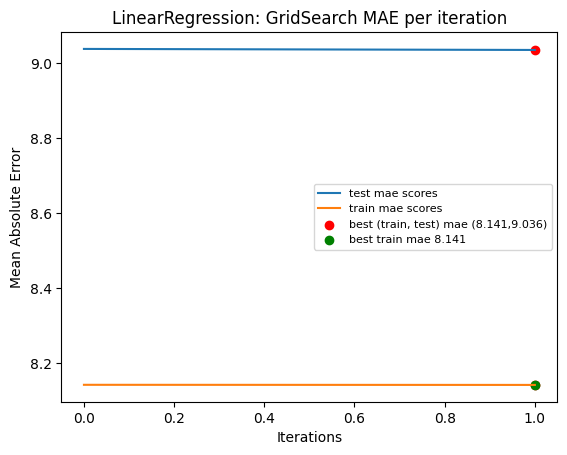

In [42]:
save_model_data('LinearRegression', best_lr_model, lr_params, lr_cv_results, lr_mae)
# plot_cv_results('LinearRegression', lr_cv_results)

In [43]:
# Decision Tree
dt_param_grid = {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
best_dt_model, dt_params, dt_cv_results, dt_mae = perform_grid_search(DecisionTreeRegressor(), dt_param_grid, X, y, 5)

Best parameters for DecisionTreeRegressor: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}


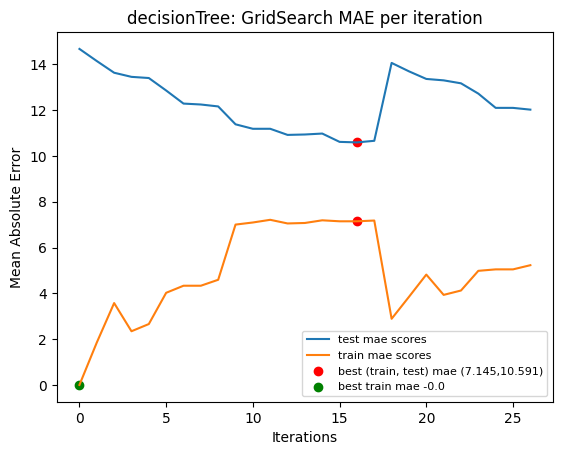

In [44]:
save_model_data('decisionTree',best_dt_model, dt_params, dt_cv_results, dt_mae)

In [45]:
# Random Forest
rf_param_grid = param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
best_rf_model, rf_params, rf_cv_results, rf_mae = perform_grid_search(RandomForestRegressor(), rf_param_grid, X, y, 5)


Best parameters for RandomForestRegressor: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}


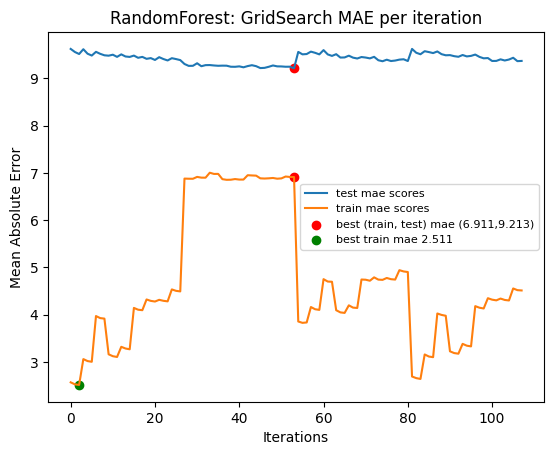

In [46]:
save_model_data('RandomForest',best_rf_model, rf_params, rf_cv_results, rf_mae)

In [47]:
# XG Boost
xgb_param_grid = xgb_param_grid = param_grid = {
    'xgbregressor__n_estimators': [50, 100, 150],
    'xgbregressor__max_depth': [3, 5, 7],
    'xgbregressor__learning_rate': [0.01, 0.1, 0.2],
    'xgbregressor__subsample': [0.8, 1.0],
    'xgbregressor__colsample_bytree': [0.8, 1.0],
}
xgb_pipeline = Pipeline([('xgbregressor', xgb.XGBRegressor())])
best_xgb_model, xgb_params, xgb_cv_results, xgb_mae = perform_grid_search(xgb_pipeline, xgb_param_grid, X, y, 5)


Best parameters for Pipeline: {'xgbregressor__colsample_bytree': 1.0, 'xgbregressor__learning_rate': 0.01, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 150, 'xgbregressor__subsample': 0.8}


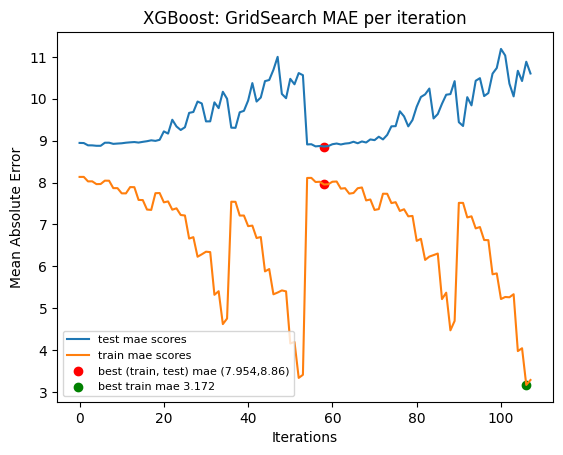

In [48]:
save_model_data('XGBoost',best_xgb_model, xgb_params,xgb_cv_results, xgb_mae)

In [63]:
# Cat Boost
catboost_grid_param_grid = {
    'catbreg__iterations': [100, 200, 300],
    'catbreg__learning_rate': [0.01, 0.05, 0.1],
    'catbreg__depth': [6, 8, 10],
    'catbreg__l2_leaf_reg': [1, 3, 5]
}

catboost_pipeline = Pipeline([('scaler', StandardScaler()), ('catbreg', CatBoostRegressor(verbose=0))])
best_catboost_model, best_cb_params, cb_cv_results, cb_mae = perform_grid_search(catboost_pipeline, catboost_grid_param_grid, X, y, 5)


Best parameters for Pipeline: {'catbreg__depth': 6, 'catbreg__iterations': 200, 'catbreg__l2_leaf_reg': 1, 'catbreg__learning_rate': 0.01}


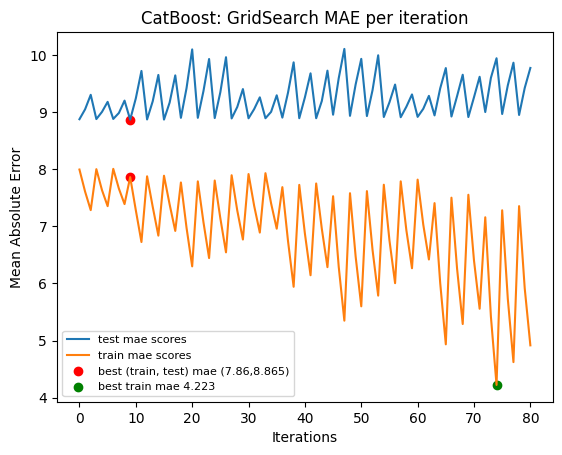

In [64]:
save_model_data('CatBoost', best_catboost_model, best_cb_params, cb_cv_results, cb_mae)

In [49]:
# Neural Network
nn_param_grid = {'mlpregressor__hidden_layer_sizes': [(100,), (50, 50)], 'mlpregressor__activation': ['relu', 'tanh'], 'mlpregressor__max_iter': [500, 1000, 2000]}
nn_pipeline = Pipeline([('scaler', StandardScaler()), ('mlpregressor', MLPRegressor())])
best_nn_model, nn_params, nn_cv_results, nn_mae = perform_grid_search(nn_pipeline, nn_param_grid, X, y, 5)


Best parameters for Pipeline: {'mlpregressor__activation': 'tanh', 'mlpregressor__hidden_layer_sizes': (100,), 'mlpregressor__max_iter': 500}


c:\Users\saman\miniconda3\envs\mlproject_py3.9\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


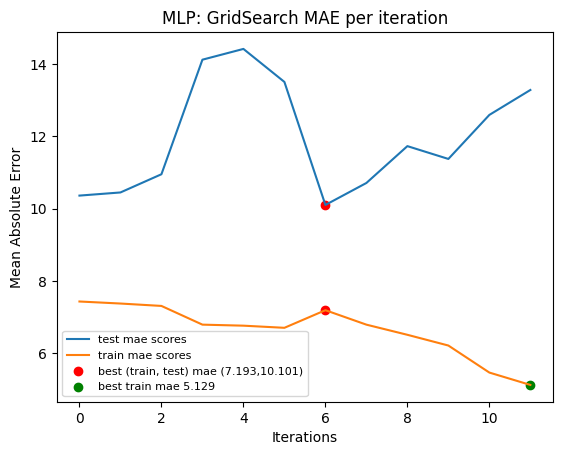

In [50]:
save_model_data('MLP',best_nn_model, nn_params, nn_cv_results, nn_mae)

In [51]:
# ARIMA
# Fine-tuning ARIMA Model

arima_model = auto_arima(y, seasonal=False, stepwise=True, error_action='ignore', trace=True)

arima_mae = mean_absolute_error(y, arima_model.predict(n_periods=len(y)))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=12.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=189182.204, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=188476.570, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=188369.853, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=189180.204, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=7.92 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=188263.665, Time=1.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=187633.047, Time=4.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=13.86 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=9.38 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=10.32 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=19.16 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=187631.047, Time=2.01 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=188261.665, Time=0.60 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=i

In [52]:
save_model_data('ARIMA', arima_model, None, None, arima_mae)

In [65]:
# Combine all reports
results = {

    'LinearRegression': lr_mae,

    'NeuralNetwork': nn_mae,

    'RandomForest': rf_mae,

    'DecisionTree': dt_mae,

    'XGBoost': xgb_mae,

    'CatBoost': cb_mae,

    'ARIMA': arima_mae

}
 
# Convert results to DataFrame

results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Average MAE'])
 
# Save the DataFrame to a CSV file

results_df.to_csv('model_cv_results.csv', index=True)

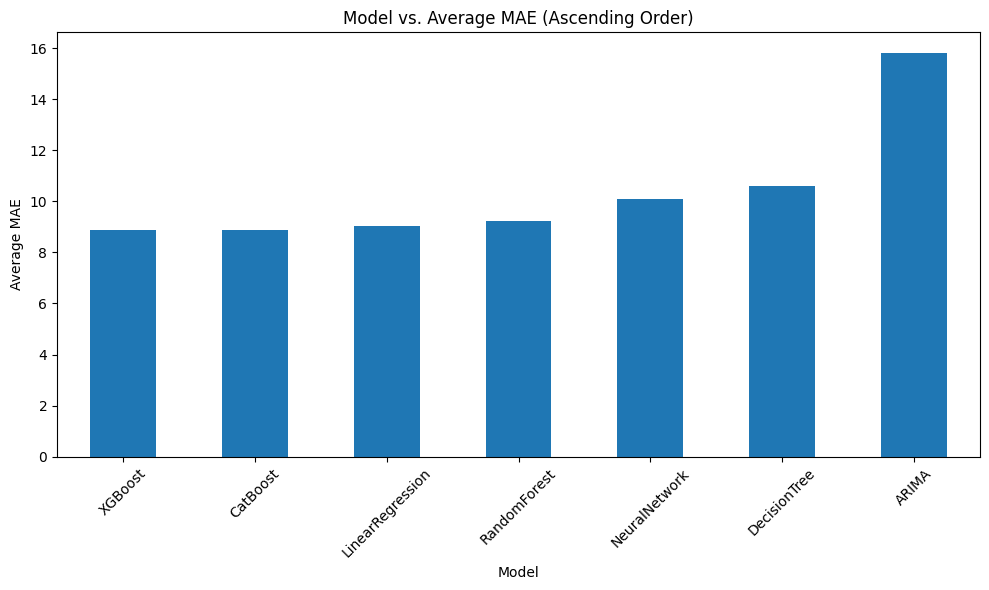

In [66]:
# Plotting Models vs Average MAE

plt.figure(figsize=(10, 6))

results_df['Average MAE'].sort_values().plot(kind='bar')

plt.xlabel('Model')

plt.ylabel('Average MAE')

plt.title('Model vs. Average MAE (Ascending Order)')

plt.xticks(rotation=45)

plt.tight_layout()

plt.savefig('final_model_comparisons.png')

In [86]:
# Performing train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=104, shuffle=False)

In [92]:
X_train.index, y_train.shape, X_test.index, y_test.shape

(Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
        ...
        21154, 21155, 21156, 21157, 21158, 21159, 21160, 21161, 21162, 21163],
       dtype='int64', length=21164),
 (21164,),
 Index([21164, 21165, 21166, 21167, 21168, 21169, 21170, 21171, 21172, 21173,
        ...
        26445, 26446, 26447, 26448, 26449, 26450, 26451, 26452, 26453, 26454],
       dtype='int64', length=5291),
 (5291,))

In [121]:
def plot_test_predictions(model_name, model):
    dir = f'./results_new/{model_name}/'
    try:
        os.makedirs(dir)
    except Exception as e:
        pass
    # save model
    joblib.dump(model, dir+f'{model_name}_fulltrain.pkl')
    predictions = model.predict(X_test)
    test_mae = mean_absolute_error(y_test, predictions)
    print(f"{model_name} MAE",test_mae)
# Reset index for predictions and y_test
    predictions = pd.Series(predictions, index=np.arange(1,len(predictions)+1))
    y_test_reset = y_test.reset_index(drop=True)
    plt.plot(predictions[:100], label='predictions')
    plt.plot(y_test_reset[:100], label='test')
    plt.legend()
    plt.xlabel('Samples')
    plt.ylabel('Target')
    plt.savefig(dir+'testvspred.png')

In [122]:
# Now let's train all the best models with the initial data
# Random Forest
randomForestModel = RandomForestRegressor(**rf_params, n_jobs=-1)
randomForestModel.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=150, n_jobs=-1)

RandomForest MAE 9.037459692016114


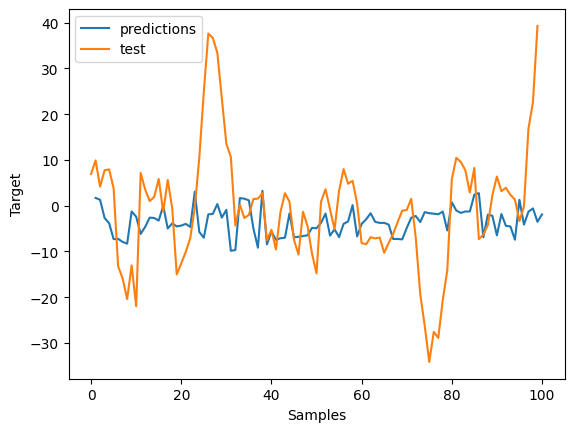

In [123]:
plot_test_predictions('RandomForest', randomForestModel)

In [124]:
decision_tree_model = DecisionTreeRegressor(**dt_params)
decision_tree_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=5)

decisionTree MAE 12.064760747975175


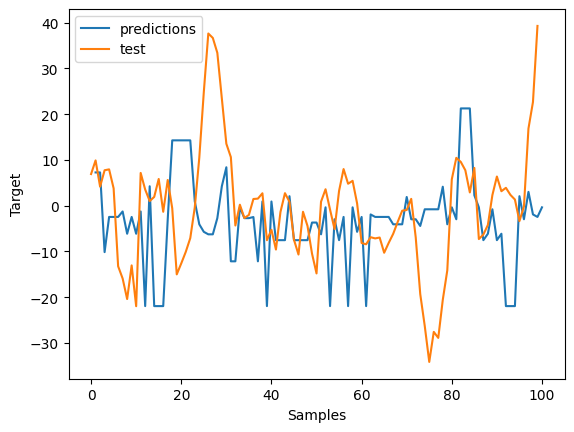

In [125]:
plot_test_predictions('decisionTree', decision_tree_model)

c:\Users\saman\miniconda3\envs\mlproject_py3.9\lib\site-packages\xgboost\core.py:160: UserWarning: [15:28:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "xgbregressor__colsample_bytree", "xgbregressor__learning_rate", "xgbregressor__max_depth", "xgbregressor__n_estimators", "xgbregressor__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost MAE 9.953676


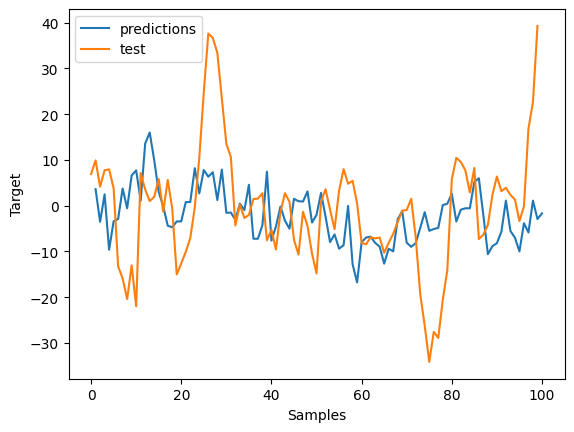

In [126]:
xgboost_model = xgb.XGBRegressor(**xgb_params)
xgboost_model.fit(X_train, y_train)
plot_test_predictions('XGBoost', xgboost_model)

CatBoost MAE 8.088586981079215


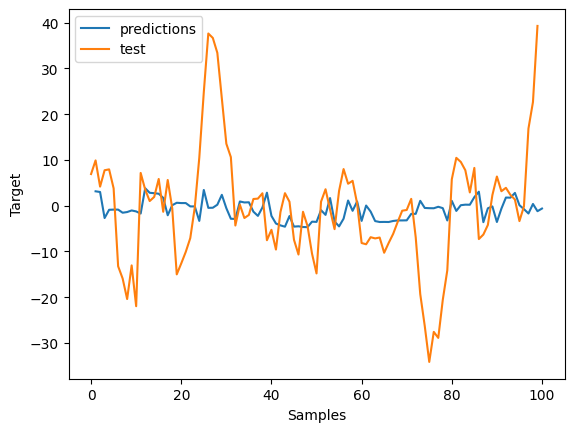

In [130]:
best_cat_params = {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
cat_model = CatBoostRegressor(**best_cat_params, verbose=0)
cat_model.fit(X_train, y_train)

plot_test_predictions('CatBoost', cat_model)

MLP MAE 8.320367


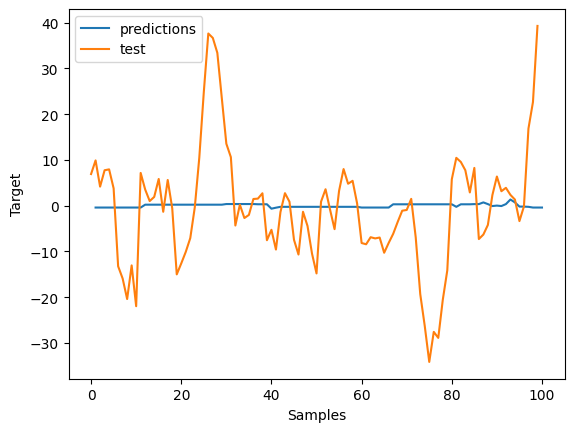

In [133]:
best_mlp = {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'max_iter': 500}
mlpModel = MLPRegressor(**best_mlp)
mlpModel.fit(X_train, y_train)
plot_test_predictions('MLP', mlpModel)